<a href="https://colab.research.google.com/github/Parado-xy/dataScience/blob/main/DCGAN-CelebA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [20]:

# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES
# TO THE CORRECT LOCATION (/kaggle/input) IN YOUR NOTEBOOK,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.

import os
import sys
from tempfile import NamedTemporaryFile
from urllib.request import urlopen
from urllib.parse import unquote, urlparse
from urllib.error import HTTPError
from zipfile import ZipFile
import tarfile
import shutil

CHUNK_SIZE = 40960
DATA_SOURCE_MAPPING = 'celeba-dataset:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F29561%2F37705%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240916%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240916T122032Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D1173be375abc944762c98777f2fad17cfb85d1a29cc1178eeba261132292af3b869fb3479d2c060dd1667c658e8839326376b0d07405bdae44359c8d666349c19163e1c24e0173a152eaf18d9c2d0eb3e029abf82bdca155f5f22ff2267feb33f483149d1975e849517c80ef225d1433a758ff6e867a220ef7c31904bd7cec345f87ab3d690672fae85c718c7e84c1df255efe6d0a85b7ce29975d4825a39b170655688ebefa2ded39a4f6941042352543d583fc2d8d03db6bd1bf6261f4c14a6824b60f63667ddf8452b4ce796f371119f2d98f0ed3a64417e0a46f67d4309e570b5acd308240a133f27b5434bc1dfa2a1000ebfd6131780eea1a39d4d86310'

KAGGLE_INPUT_PATH='/kaggle/input'
KAGGLE_WORKING_PATH='/kaggle/working'
KAGGLE_SYMLINK='kaggle'

!umount /kaggle/input/ 2> /dev/null
shutil.rmtree('/kaggle/input', ignore_errors=True)
os.makedirs(KAGGLE_INPUT_PATH, 0o777, exist_ok=True)
os.makedirs(KAGGLE_WORKING_PATH, 0o777, exist_ok=True)

try:
  os.symlink(KAGGLE_INPUT_PATH, os.path.join("..", 'input'), target_is_directory=True)
except FileExistsError:
  pass
try:
  os.symlink(KAGGLE_WORKING_PATH, os.path.join("..", 'working'), target_is_directory=True)
except FileExistsError:
  pass

for data_source_mapping in DATA_SOURCE_MAPPING.split(','):
    directory, download_url_encoded = data_source_mapping.split(':')
    download_url = unquote(download_url_encoded)
    filename = urlparse(download_url).path
    destination_path = os.path.join(KAGGLE_INPUT_PATH, directory)
    try:
        with urlopen(download_url) as fileres, NamedTemporaryFile() as tfile:
            total_length = fileres.headers['content-length']
            print(f'Downloading {directory}, {total_length} bytes compressed')
            dl = 0
            data = fileres.read(CHUNK_SIZE)
            while len(data) > 0:
                dl += len(data)
                tfile.write(data)
                done = int(50 * dl / int(total_length))
                sys.stdout.write(f"\r[{'=' * done}{' ' * (50-done)}] {dl} bytes downloaded")
                sys.stdout.flush()
                data = fileres.read(CHUNK_SIZE)
            if filename.endswith('.zip'):
              with ZipFile(tfile) as zfile:
                zfile.extractall(destination_path)
            else:
              with tarfile.open(tfile.name) as tarfile:
                tarfile.extractall(destination_path)
            print(f'\nDownloaded and uncompressed: {directory}')
    except HTTPError as e:
        print(f'Failed to load (likely expired) {download_url} to path {destination_path}')
        continue
    except OSError as e:
        print(f'Failed to load {download_url} to path {destination_path}')
        continue

print('Data source import complete.')


[==================================================] 1427750792 bytes downloaded
Downloaded and uncompressed: celeba-dataset
Data source import complete.


In [21]:
# Let's make a DCGAN for the Celeb-A dataset.

In [22]:
# Import the required libraries.
import tensorflow as tf
from tensorflow import keras
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [23]:
# Let's import the dataset.
# I'll resize the images to 64 x 64 rgb images.

# Set the image size variable.
image_size = (64,64)
dataset = keras.utils.image_dataset_from_directory(
    directory = '/kaggle/input/celeba-dataset/img_align_celeba/img_align_celeba',
    labels = None,
    shuffle = True,
    image_size = image_size,
    color_mode = 'rgb',
    interpolation = 'bilinear'
)

Found 202599 files.


In [24]:
# Rescale the images to the [-1,1] range so we can use the tanh function.
def rescale(img):
     """Re-Scale the images to the [-1, 1] range."""
     img = (tf.cast(img, 'float32') - 127.5) / 127.5
     return img

dataset = dataset.map(lambda x: rescale(x))

In [25]:
# Let's define the discriminator.
def discriminator():
    discriminator_input = keras.Input(shape =(64,64,3,))
    x = keras.layers.Conv2D(64, kernel_size = 3, padding = 'same', strides = 2, use_bias = False)(discriminator_input)
    x = keras.layers.LeakyReLU(0.2)(x)
    x = keras.layers.BatchNormalization(momentum = 0.9)(x)

    x = keras.layers.SeparableConv2D(64, kernel_size = 3, strides = 2, padding = 'same', use_bias = False)(x)
    x = keras.layers.BatchNormalization(momentum = 0.9)(x)
    x = keras.layers.LeakyReLU(0.2)(x)
    x = keras.layers.Dropout(0.25)(x)

    x = keras.layers.SeparableConv2D(128, kernel_size = 3, strides = 2, padding = 'same', use_bias = False)(x)
    x = keras.layers.BatchNormalization(momentum = 0.9)(x)
    x = keras.layers.LeakyReLU(0.2)(x)
    x = keras.layers.Dropout(0.25)(x)

    x = keras.layers.SeparableConv2D(256, kernel_size = 3, strides = 2, padding = 'same', use_bias = False)(x)
    x = keras.layers.BatchNormalization(momentum = 0.9)(x)
    x = keras.layers.LeakyReLU(0.2)(x)
    x = keras.layers.Dropout(0.25)(x)

    x = keras.layers.SeparableConv2D(512, kernel_size = 3, strides = 2, padding = 'same', use_bias = False)(x)
    x = keras.layers.BatchNormalization(momentum = 0.9)(x)
    x = keras.layers.LeakyReLU(0.2)(x)
    x = keras.layers.Dropout(0.25)(x)

    x = keras.layers.SeparableConv2D(1, kernel_size = 3, strides = 2, padding = 'same', use_bias = False, activation = 'sigmoid')(x)
    discriminator_output = keras.layers.Flatten()(x) # FLatten the input so i can be a single value in the [0,1] range.

    return keras.Model(discriminator_input, discriminator_output, name = 'discriminator')


Discriminator_model = discriminator()
Discriminator_model.summary()

Model: "discriminator"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)           │ (None, 64, 64, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 32, 32, 64)          │           1,728 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_5 (LeakyReLU)            │ (None, 32, 32, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_10               │ (None, 32, 32, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ separable_conv2d_5 (SeparableConv2D) │ (None, 16, 16, 64)          │           4,672 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_11               │ (None, 16, 16, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_6 (LeakyReLU)            │ (None, 16, 16, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 16, 16, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ separable_conv2d_6 (SeparableConv2D) │ (None, 8, 8, 128)           │           8,768 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_12               │ (None, 8, 8, 128)           │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_7 (LeakyReLU)            │ (None, 8, 8, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_5 (Dropout)                  │ (None, 8, 8, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ separable_conv2d_7 (SeparableConv2D) │ (None, 4, 4, 256)           │          33,920 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_13               │ (None, 4, 4, 256)           │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_8 (LeakyReLU)            │ (None, 4, 4, 256)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_6 (Dropout)                  │ (None, 4, 4, 256)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ separable_conv2d_8 (SeparableConv2D) │ (None, 2, 2, 512)           │         133,376 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_14               │ (None, 2, 2, 512)           │           2,048 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_9 (LeakyReLU)            │ (None, 2, 2, 512)           │              

 Total params: 191,680 (748.75 KB)

 Trainable params: 189,632 (740.75 KB)

 Non-trainable params: 2,048 (8.00 KB)

In [26]:
def generator(latent_dimension):
    generator_input = keras.Input(shape = (latent_dimension,))
    x = keras.layers.Reshape((1,1,latent_dimension))(generator_input)
    x = keras.layers.Conv2DTranspose(512, kernel_size = 3, use_bias = False, strides = 2, padding = 'same')(x)
    x = keras.layers.BatchNormalization(momentum = 0.9)(x)
    x = keras.layers.ReLU()(x)

    x = keras.layers.Conv2DTranspose(256, kernel_size = 3, use_bias = False, strides = 2,  padding = 'same')(x)
    x = keras.layers.BatchNormalization(momentum = 0.9)(x)
    x = keras.layers.ReLU()(x)

    x = keras.layers.Conv2DTranspose(128, kernel_size = 3, use_bias = False, strides = 2, padding = 'same')(x)
    x = keras.layers.BatchNormalization(momentum = 0.9)(x)
    x = keras.layers.ReLU()(x)

    x = keras.layers.Conv2DTranspose(64, kernel_size = 3, use_bias = False, strides = 2,  padding = 'same')(x)
    x = keras.layers.BatchNormalization(momentum = 0.9)(x)
    x = keras.layers.ReLU()(x)

    x = keras.layers.Conv2DTranspose(32, kernel_size = 3, use_bias = False, strides = 2,  padding = 'same')(x)
    x = keras.layers.BatchNormalization(momentum = 0.9)(x)
    x = keras.layers.ReLU()(x)

    generator_output = keras.layers.Conv2DTranspose(3, kernel_size = 3, use_bias = False, strides = 2,  padding = 'same', activation = 'tanh')(x)
    return keras.Model(generator_input, generator_output, name = 'generator')

Generator_model = generator(100)
Generator_model.summary()

Model: "generator"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)           │ (None, 100)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ reshape_1 (Reshape)                  │ (None, 1, 1, 100)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose_6 (Conv2DTranspose) │ (None, 2, 2, 512)           │         460,800 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_15               │ (None, 2, 2, 512)           │           2,048 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ re_lu_5 (ReLU)                       │ (None, 2, 2, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose_7 (Conv2DTranspose) │ (None, 4, 4, 256)           │       1,179,648 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_16               │ (None, 4, 4, 256)           │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ re_lu_6 (ReLU)                       │ (None, 4, 4, 256)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose_8 (Conv2DTranspose) │ (None, 8, 8, 128)           │         294,912 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_17               │ (None, 8, 8, 128)           │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ re_lu_7 (ReLU)                       │ (None, 8, 8, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose_9 (Conv2DTranspose) │ (None, 16, 16, 64)          │          73,728 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_18               │ (None, 16, 16, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ re_lu_8 (ReLU)                       │ (None, 16, 16, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose_10                  │ (None, 32, 32, 32)          │          18,432 │
│ (Conv2DTranspose)                    │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_19               │ (None, 32, 32, 32)          │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ re_lu_9 (ReLU)                       │ (None, 32, 32, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose_11                  │ (None, 64, 64, 3)           │             864 │
│ (Conv2DTranspose)                    │                             │              

 Total params: 2,032,352 (7.75 MB)

 Trainable params: 2,030,368 (7.75 MB)

 Non-trainable params: 1,984 (7.75 KB)

In [27]:
class DCGAN(keras.Model):
    def __init__(self, discriminator, generator, latent_dim ):
        super(DCGAN, self).__init__()
        self.discriminator = discriminator
        self.generator = generator
        self.latent_dim = latent_dim

    def compile(self, discriminator_optimizer, generator_optimizer):
        super(DCGAN, self).compile()
        self.loss_function = keras.losses.BinaryCrossentropy()
        self.discriminator_optimizer = discriminator_optimizer
        self.generator_optimizer = generator_optimizer
        self.discriminator_loss_metrics = keras.metrics.Mean(name = 'discriminator_loss')
        self.generator_loss_metrics = keras.metrics.Mean(name = 'generator_loss')

    @property
    def metrics(self):
        return [self.discriminator_loss_metrics, self.generator_loss_metrics]

    def train_step(self, real_images):
        batch_size = tf.shape(real_images)[0]
        random_vectors = tf.random.normal(shape = (batch_size, self.latent_dim))

        with tf.GradientTape() as discriminator_tape, tf.GradientTape() as generator_tape:
            # Generate fake images via the generator.
            fake_images = self.generator(random_vectors, training = True)

            # Make predictions on both fake and real images.
            real_predictions = self.discriminator(real_images, training = True)
            fake_predictions = self.discriminator(fake_images, training = True)

            # Create labels for real and fake images.
            real_labels = tf.ones_like(real_predictions)
            fake_labels = tf.zeros_like(fake_predictions)

            # Create noisy labels (Label Smoothening)
            noisy_real_labels = real_labels - 0.1 * tf.random.uniform(shape = tf.shape(real_labels))
            noisy_fake_labels = fake_labels + 0.1 * tf.random.uniform(shape = tf.shape(fake_labels))

            # Discriminator Loss
            # Note that the losses are computed between the true values and the predicted values.
            discriminator_fake_losses = self.loss_function(noisy_fake_labels, fake_predictions)
            discriminator_real_losses = self.loss_function(noisy_real_labels, real_predictions)

            discriminator_loss = (discriminator_real_losses + discriminator_fake_losses) / 2

            # Generator Loss
            generator_loss = self.loss_function(real_labels, fake_predictions)

        # Compute gradient
        gradients_of_discriminator = discriminator_tape.gradient(discriminator_loss, self.discriminator.trainable_variables)
        gradients_of_generator = generator_tape.gradient(generator_loss, self.generator.trainable_variables)

        # Apply gradients
        self.discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, self.discriminator.trainable_variables))
        self.generator_optimizer.apply_gradients(zip(gradients_of_generator, self.generator.trainable_variables))

        # Update metrics.
        self.discriminator_loss_metrics.update_state(discriminator_loss)
        self.generator_loss_metrics.update_state(generator_loss)

        return {m.name : m.result() for m in self.metrics}




In [28]:
dcgan = DCGAN(discriminator = Discriminator_model, generator = Generator_model, latent_dim = 100) # Initialize the DCGAN
dcgan.compile(
    discriminator_optimizer = keras.optimizers.Adam(learning_rate = 0.0002, beta_1 = 0.5, beta_2 = 0.999),
    generator_optimizer = keras.optimizers.Adam(learning_rate = 0.0002, beta_1 = 0.5, beta_2 = 0.999)
)

# The fit step.
history = dcgan.fit(dataset, epochs = 30)

Epoch 1/30
6332/6332 ━━━━━━━━━━━━━━━━━━━━ 139s 17ms/step - discriminator_loss: 0.6195 - generator_loss: 0.9172
Epoch 2/30
6332/6332 ━━━━━━━━━━━━━━━━━━━━ 102s 16ms/step - discriminator_loss: 0.6830 - generator_loss: 0.7310
Epoch 3/30
6332/6332 ━━━━━━━━━━━━━━━━━━━━ 94s 15ms/step - discriminator_loss: 0.6839 - generator_loss: 0.7225
Epoch 4/30
6332/6332 ━━━━━━━━━━━━━━━━━━━━ 95s 15ms/step - discriminator_loss: 0.6327 - generator_loss: 0.8499
Epoch 5/30
6332/6332 ━━━━━━━━━━━━━━━━━━━━ 94s 15ms/step - discriminator_loss: 0.5586 - generator_loss: 1.1046
Epoch 6/30
6332/6332 ━━━━━━━━━━━━━━━━━━━━ 142s 15ms/step - discriminator_loss: 0.5141 - generator_loss: 1.2947
Epoch 7/30
6332/6332 ━━━━━━━━━━━━━━━━━━━━ 142s 15ms/step - discriminator_loss: 0.4789 - generator_loss: 1.4789
Epoch 8/30
6332/6332 ━━━━━━━━━━━━━━━━━━━━ 95s 15ms/step - discriminator_loss: 0.4624 - generator_loss: 1.6002
Epoch 9/30
6332/6332 ━━━━━━━━━━━━━━━━━━━━ 94s 15ms/step - discriminator_loss: 0.4482 - generator_loss: 1.6811
Epoch 

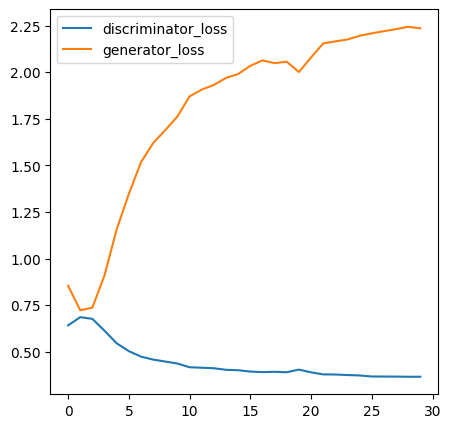

In [50]:
# history = pd.DataFrame(history.history)
history.plot(figsize = (5,5))
plt.show()

In [30]:
# Note, we should rescale the image to the 0 - 255 range.



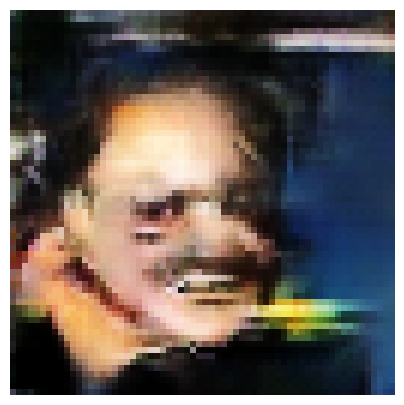

In [46]:
image = Generator_model(tf.random.normal(shape = (1,100)))
image = np.array(((image) + 1) * 127.5).astype('uint8')
plt.figure(figsize=(5, 5))
plt.axis('off')
plt.imshow(image[0])

In [60]:
Generator_model.save('generator.keras')
Discriminator_model.save('discriminator.keras')

In [ ]:
# Well, E for effort i guess.